**TODO**: 
- [x] improve progress bar
- [] remove early races?
- [x] migliora splitting di tr/vl (correggere validation che include test)
- [x] introduce `race_country == nationality`
- [x] recompute `is_tarmac`
- [] can we reorder seasons from colder to warmer? does it make sense?
- [] try different sampling strategy
- [x] use GPU (hopefully speeds up grid search)
- [] retrain model using all the development set
- [] decide the important metrics (probaly f1 and precision/recall of winners)
- [] study hyperparameter of XGB
- [] grid search for FBT (it is not giving good results)
- [] compare with normal tree
- [] compute metrics of FBT
- [] refactor this notebook
- [] how does the prediction changes changing one input (explainability)

# CREATING THE DATASET

In [1]:
# As always we start by importing the necessary libraries
# and loading the data we will be working with. (at this point I'm importing stuff just for the fun of it)
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utility.classification_utility import *

# we define a random state to make the results reproducible
RANDOM_STATE = 42
RUN_SLOW_STUFF = True

cyc = '../dataset/cyclists_cleaned.csv'
races = '../dataset/races_cleaned.csv'

full_df = get_merged_dataset(cyc, races)
full_df = define_target(full_df) 

In [2]:
#full_df = define_target(full_df)
full_df[['points', 'position', 'average_speed', 'stamina_index']]
print('points:', full_df['points'].isna().sum())
print('position:',full_df['position'].isna().sum())
print('average_speed:',full_df['average_speed'].isna().sum())
print('stamina_index:',full_df['stamina_index'].isna().sum())

points: 0
position: 0
average_speed: 0
stamina_index: 137267


In [3]:
full_df.columns

Index(['_url_rac', 'name_rac', 'stage', 'stage_type', 'points', 'uci_points',
       'length', 'climb_total', 'profile', 'startlist_quality', 'date',
       'position', 'cyclist', 'cyclist_age_rac', 'is_tarmac', 'delta', 'time',
       'time_seconds', 'average_speed', 'steepness', 'season', 'is_staged',
       'race_country', 'norm_points', 'age_performance_index',
       'quality_adjusted_points', 'normalized_length', 'normalized_quality',
       'normalized_steepness', 'normalized_time', 'stamina_index', '_url_cyc',
       'name_cyc', 'birth_year', 'weight', 'height', 'nationality', 'bmi',
       'race_count', 'experience_level', 'total_points', 'victories_by_points',
       'avg_points_per_race', 'average_position', 'avg_speed_cyclist',
       'cyclist_age_cyc', 'mean_stamina_index', 'target'],
      dtype='object')

In [4]:
full_df = recompute_metrics(full_df,
                  avg_points_per_race_D=-1,
                  average_position_D=-1,
                  avg_speed_cyclist_D=-1,
                  mean_stamina_index=-1,
                  total_points_D=-1,
                  missing_value_policy='mean')

100.00%  


In [5]:
full_df = define_target(full_df)

## Let's see if everything seems reasonable

In [6]:
stef = full_df[full_df['cyclist'] == 'tadej-pogacar']
stef_sorted = stef.sort_values(by='date')
stef_sorted[['_url_rac', 'cyclist', 'points', 'total_points', 'date', 'position', 'avg_points_per_race']]

,_url_rac,cyclist,points,total_points,date,position,avg_points_per_race
449815,strade-bianche/2019/result,tadej-pogacar,5.0,-1.0,2019-03-09,29,-1.000000
453134,itzulia-basque-country/2019/stage-2,tadej-pogacar,2.0,5.0,2019-04-09,8,5.000000
453339,itzulia-basque-country/2019/stage-3,tadej-pogacar,0.0,7.0,2019-04-10,77,3.500000
453386,itzulia-basque-country/2019/stage-5,tadej-pogacar,10.0,7.0,2019-04-12,4,2.333333
453568,itzulia-basque-country/2019/stage-6,tadej-pogacar,10.0,17.0,2019-04-13,4,4.250000
...,...,...,...,...,...,...,...
522371,tour-de-france/2023/stage-16,tadej-pogacar,70.0,5178.0,2023-07-18,1,35.958333
522399,tour-de-france/2023/stage-17,tadej-pogacar,0.0,5248.0,2023-07-19,21,36.193103
522631,tour-de-france/2023/stage-18,tadej-pogacar,0.0,5248.0,2023-07-20,25,35.945205
522749,tour-de-france/2023/stage-19,tadej-pogacar,0.0,5248.0,2023-07-21,41,35.700680


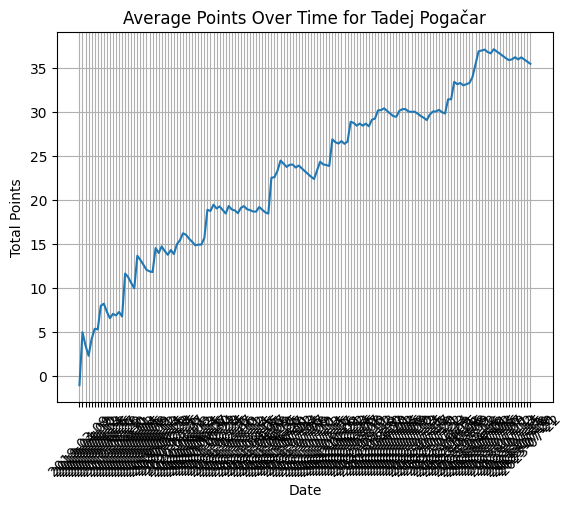

In [7]:
total_points = list(stef_sorted['avg_points_per_race'])
plt.plot(stef_sorted['date'], total_points)
plt.xlabel('Date')
plt.ylabel('Total Points')
plt.title('Average Points Over Time for Tadej Pogačar')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [8]:
full_df[['position', 'target']]

,position,target
0,29,False
1,15,True
2,16,True
3,17,True
4,18,True
...,...,...
523068,15,True
523069,16,True
523070,17,True
523071,8,True


## Prepare dataset for XGB (other models may have different preparaton)

In [9]:
'race_country' == 'nationality'
'experience_level' # to encode
'is_tarmac' # recompute as int (0, 1) for explainability
'season', # explainability can't handle categorical data

dataset = full_df.copy()

dataset['is_tarmac'] = dataset['is_tarmac'].astype(int)
dataset['experience_level'] = dataset['experience_level'].apply(lambda x: EXPERIENCE_LEVELS.index(x))
dataset['home_game'] = dataset.apply(lambda x: 1 if x['race_country'] == x['nationality'] else 0, axis=1)

TO_USE_COLS = [
    # over time
    'total_points', 'avg_points_per_race', 
    'average_position', 'avg_speed_cyclist', 'mean_stamina_index',
    'race_count',
    # race related
    'uci_points', 'length', 'climb_total', 'profile', 
    'startlist_quality', 'cyclist_age_rac', 'steepness', 
    'is_tarmac',
    # cyclist related
    'weight', 'height', 'bmi',
    'experience_level', 'home_game',
]

# TRAINING VALIDATION TEST SPLIT
tr_data = dataset[dataset['date'] < '2019-01-01']
print(tr_data['date'].min(), tr_data['date'].max())
tr_out = tr_data['target']
tr_data = tr_data[TO_USE_COLS]

val_data = dataset[dataset['date'] >= '2019-01-01'][dataset['date'] < '2022-01-01']
print(val_data['date'].min(), val_data['date'].max())
val_out = val_data['target']
val_data = val_data[TO_USE_COLS]

ts_data = dataset[dataset['date'] >= '2022-01-01']
print(ts_data['date'].min(), ts_data['date'].max())
ts_out = ts_data['target']
ts_data = ts_data[TO_USE_COLS]

print('Training data:', tr_data.shape, 'i.e.', f'{(tr_data.shape[0] / full_df.shape[0])*100:.2f}', '%')
print('Validation data:', val_data.shape, 'i.e.', f'{(val_data.shape[0] / full_df.shape[0])*100:.2f}', '%')
print('Test data:', ts_data.shape, 'i.e.', f'{(ts_data.shape[0] / full_df.shape[0])*100:.2f}', '%')

print(f'Percentage of positive samples in training data: {tr_out.mean()}')
print(f'Percentage of positive samples in validation data: {val_out.mean()}')

1970-02-28 2018-10-13
2019-02-26 2021-10-09
2022-02-21 2023-07-29
Training data: (449164, 19) i.e. 85.87 %
Validation data: (43480, 19) i.e. 8.31 %
Test data: (30429, 19) i.e. 5.82 %
Percentage of positive samples in training data: 0.1767795281901488
Percentage of positive samples in validation data: 0.14344526218951242


/tmp/ipykernel_1589/1981730520.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_data = dataset[dataset['date'] >= '2019-01-01'][dataset['date'] < '2022-01-01']


# XGB grid search

## GPU

In [10]:
from random import shuffle
from xgboost import XGBClassifier # XGBoost classifier
import xgboost as xgb
from itertools import product #for grid search
from tqdm import tqdm # for progress bar
from sklearn.metrics import classification_report, f1_score # for evaluation
from imblearn.over_sampling import RandomOverSampler # for oversampling
def f1_macro(x, y):     # for our evaluation
    return f1_score(x, y, average='macro')

oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
tr_data, tr_out = oversample.fit_resample(tr_data, tr_out)
tr_data = tr_data.reset_index(drop=True)
tr_out = tr_out.reset_index(drop=True)

dtrain = xgb.DMatrix(tr_data, label=tr_out, enable_categorical=True)
#Xy = xgb.QuantileDMatrix(tr_data, label=tr_out, enable_categorical=True)
dval = xgb.DMatrix(val_data, enable_categorical=True)

N_estimators = [30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]
Learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
hyperparameters = list(product(N_estimators, Learning_rate))
shuffle(hyperparameters)

best_score = 0
best_params = None

for n_estimators, learning_rate in tqdm(hyperparameters, total=len(hyperparameters), colour='green', smoothing=0.4):
    params = {
        'eta': learning_rate, 
        'objective': 'binary:logistic', 
        #'n_estimators': n_estimators,
        'device': 'cuda',
        'tree_method': 'hist',
        }
    model = xgb.train(params, dtrain, num_boost_round=n_estimators)
    val_pred = model.predict(dval)
    val_pred = (val_pred > 0.5).astype(int)
    score = f1_macro(val_out, val_pred)
    if score > best_score:
        best_score = score
        best_params = (n_estimators, learning_rate)

print(f'Best score: {best_score:.4f}')
print(f'Best parameters: {best_params}')

100%|██████████| 55/55 [02:05<00:00,  2.29s/it]

Best score: 0.7051
Best parameters: (400, 0.1)


## CPU

In [11]:
if False:
    from random import shuffle
    from xgboost import XGBClassifier # XGBoost classifier
    import xgboost as xgb
    from itertools import product #for grid search
    from tqdm import tqdm # for progress bar
    from sklearn.metrics import classification_report, f1_score # for evaluation

    from imblearn.over_sampling import RandomOverSampler # for oversampling
    f1_macro = lambda x, y: f1_score(x, y, average='macro') # for our evaluation

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=42)
    tr_data, tr_out = oversample.fit_resample(tr_data, tr_out)
    tr_data = tr_data.reset_index(drop=True)
    tr_out = tr_out.reset_index(drop=True)

    # Hyperparameters
    N_estimators = [30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400]
    # N_estimators = [200]
    Learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
    # Learning_rate = [0.1]
    # Shuffle hyperparameters to have a more accurate progress bar
    hyperparameters = list(product(N_estimators, Learning_rate))
    shuffle(hyperparameters)

    # Grid search
    best_score = 0
    best_params = None
    for n_estimators, learning_rate in tqdm(hyperparameters, total=len(hyperparameters), colour='green', smoothing=0.4):
        xgb_model = XGBClassifier(
            n_estimators=n_estimators, 
            learning_rate=learning_rate, 
            n_jobs=-1, 
            random_state=42,
            objective='binary:logistic',
        )
        xgb_model.fit(tr_data, tr_out)
        val_pred = xgb_model.predict(val_data)
        score = f1_macro(val_out, val_pred)
        if score > best_score:
            best_score = score
            best_params = (n_estimators, learning_rate)

    # Train the model with the best hyperparameters
    n_estimators, learning_rate = best_params
    xgb_model = XGBClassifier(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        n_jobs=-1, 
        random_state=42,
        objective='binary:logistic',
        device='cuda'
    )
    xgb_model.fit(tr_data, tr_out)

    # Predict
    val_pred = xgb_model.predict(val_data)
    print(f'val f1-score: {f1_macro(val_out, val_pred)}')
    print(classification_report(val_out, val_pred))
    print(f'Best hyperparameters: {best_params}')
    print(f'Best score: {best_score}')

  0%|          | 0/55 [00:00<?, ?it/s]/home/d.borghini/miniconda3/envs/dm/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:19:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
100%|██████████| 55/55 [02:35<00:00,  2.83s/it]


val f1-score: 0.7046674267895487
              precision    recall  f1-score   support

       False       0.94      0.84      0.89     37243
        True       0.42      0.69      0.52      6237

    accuracy                           0.82     43480
   macro avg       0.68      0.76      0.70     43480
weighted avg       0.87      0.82      0.84     43480

Best hyperparameters: (400, 0.15)
Best score: 0.7046674267895487


# Paper explainability (XGBoostTreeApproximator)

In [12]:
sys.path.append(os.path.abspath(os.path.join('../../XGBoostTreeApproximator'))) # find the repo of FBT
# add to requirements.txt
# pyod-2.0.3
# numba-0.60.0
# llvmlite-0.43.0
print(sys.path)
from FBT import *

['/home/d.borghini/miniconda3/envs/dm/lib/python312.zip', '/home/d.borghini/miniconda3/envs/dm/lib/python3.12', '/home/d.borghini/miniconda3/envs/dm/lib/python3.12/lib-dynload', '', '/home/d.borghini/miniconda3/envs/dm/lib/python3.12/site-packages', '/home/d.borghini/miniconda3/envs/dm/lib/python3.12/site-packages/setuptools/_vendor', '/home/d.borghini/Documents/GitHub/Project-Hephaestus', '/home/d.borghini/Documents/GitHub/XGBoostTreeApproximator']


In [13]:
import re
type(tr_data)
strings_ = xgb_model._Booster.get_dump()
#                                  indice                colonna       <   valore               
feature_regex = re.compile('\D+(?P<node_index>\d+):\[(?P<feature>[^<]+)<(?P<value>[^\]]+)\D+(?P<left>\d+)\D+(?P<right>\d+)\D+(?P<missing>\d+)')
leaf_regex = re.compile('\D+(?P<node_index>\d+)[^\=]+=(?P<prediction>.+)')
trees = []
#print('strings:', strings_[0])
# for tree_string in strings_:
#         nodes = [feature_regex.search('t' + node).groupdict() if '[' in node else leaf_regex.search('t' +node).groupdict() for node in tree_string.split('\n')[:-1]]
#         trees.append(nodes)
tree_string = strings_[0]
for node in tree_string.split('\n')[:-1]:
        break
        print('node:', node)
        if '[' in node:
                print('feature:', feature_regex.search('t' + node).groupdict())
        else:
                print('leaf:', leaf_regex.search('t' +node).groupdict())

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_1589/1301015955.py:5: SyntaxWarning: invalid escape sequence '\D'
  feature_regex = re.compile('\D+(?P<node_index>\d+):\[(?P<feature>[^<]+)<(?P<value>[^\]]+)\D+(?P<left>\d+)\D+(?P<right>\d+)\D+(?P<missing>\d+)')
/tmp/ipykernel_1589/1301015955.py:6: SyntaxWarning: invalid escape sequence '\D'
  leaf_regex = re.compile('\D+(?P<node_index>\d+)[^\=]+=(?P<prediction>.+)')


In [18]:
# for this exacution I've actually executed on the vlidation set
# it is taking very long to complete (in 15 min is at the first step of the alg (the prining))
# FOr this the explainability will be probably done on a reaaly small subset of the dataset
# It gave an error XD
fbt = FBT(max_depth=6,max_number_of_conjunctions=1000,min_forest_size=10,pruning_method='auc')
expl_data = tr_data.merge(tr_out, left_index=True, right_index=True)
#print(expl_data)
expl_data = expl_data.dropna()
expl_data = expl_data.sample(n=400).reset_index(drop=True)
expl_data['target'] = expl_data['target'].astype(int)
fbt.fit(expl_data,TO_USE_COLS,'target',xgb_model)

Start pruning
Pruned forest training set AUC: 1.0
Create conjunction set from training data instances
Number of conjunctions created from data: 289
Create complete conjunction set
Size at iteration 2: 1001
Size at iteration 3: 1001
Size at iteration 4: 1001
Size at iteration 5: 1001
Size at iteration 6: 1001
Size at iteration 7: 1001
Size at iteration 8: 1001
Size at iteration 9: 1001
Size at iteration 10: 1001
Size at iteration 11: 1001
Start ordering conjunction set in a tree structure
Construction of tree has been completed


In [23]:
predictions = fbt.predict(expl_data[TO_USE_COLS][10:20])
print('predictions:', list(predictions))
print('target     :', list(expl_data['target'][10:20]))
print('percentage of 0:', np.mean(expl_data['target'] == 0))

predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
target     : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
percentage of 0: 0.055


In [24]:
l = fbt.get_decision_paths(expl_data[TO_USE_COLS])
pred = fbt.predict(expl_data[TO_USE_COLS])
i = 103
print(f'classified as : {pred[i]} while truth is {expl_data["target"][i]}')
print('decisions:')
for d in l[i]:
    print(d)

classified as : 1 while truth is 1
decisions:
uci_points < 21.0
is_tarmac >= 1.0
average_position < 64.375
average_position >= 48.6982765
startlist_quality < 1101.0
cyclist_age_rac < 27.0
labels: [0.33703226 0.66296774]


In [25]:
pred = fbt.predict(val_data)
print(f'f1-score: {f1_macro(val_out, pred)}')
print(classification_report(val_out, pred))

f1-score: 0.21074873059604854
              precision    recall  f1-score   support

       False       0.99      0.08      0.15     37243
        True       0.15      1.00      0.27      6237

    accuracy                           0.21     43480
   macro avg       0.57      0.54      0.21     43480
weighted avg       0.87      0.21      0.17     43480

